<a href="https://colab.research.google.com/github/dawg-at-irya/Analysis_of_a_light_curve/blob/main/Analysis_of_a_light_curve.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## In this notebook, I present a simple code to smooth a periodic signal such as a light curve. We will see that through visual inspection, the signal is improved, and furthermore, when examining the power spectrum of the signal, noise peaks are eliminated. The second part of this notebook demonstrates how to determine which period peaks correspond to the signal and which ones are noise using the tools from the `savgol_filter` funtion and the `find_peaks` function to identify signal peaks.

In [1]:
from astropy.table import Table, join,Column
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import savgol_filter
from astropy.timeseries import TimeSeries
from astropy.timeseries import LombScargle
from scipy import signal

In [2]:
stars_list=['IRAS_05052-8420','IRAS_05150-4056','IRAS_05027-2158','IRAS_07034-3551']
s=-1
# The following version avoids requiring local copies of the input files
data=Table.read('https://raw.githubusercontent.com/dawg-at-irya/Analysis_of_a_light_curve/main/'+stars_list[s]+'.csv')
data.sort('JD')

# Constructing a periodogram with a smoothed light curve


This is a light curve for a star that, through visual inspection, appears as an irregular star. This light curve combines observations from different observatories around the globe, which introduces a lot of noise in the data. It appears that there are two light curves with the same pulsation pattern, but slightly separated in magnitude.

In [3]:
#Here, we are looking for the range of magnitude values to display the majority of the data.
mag_median = np.nanmedian(data['Magnitude'])
madm_median = np.nanmedian(np.abs(data['Magnitude'] - mag_median)) 

Text(0.5, 1.0, 'Light curve for IRAS_07034-3551')

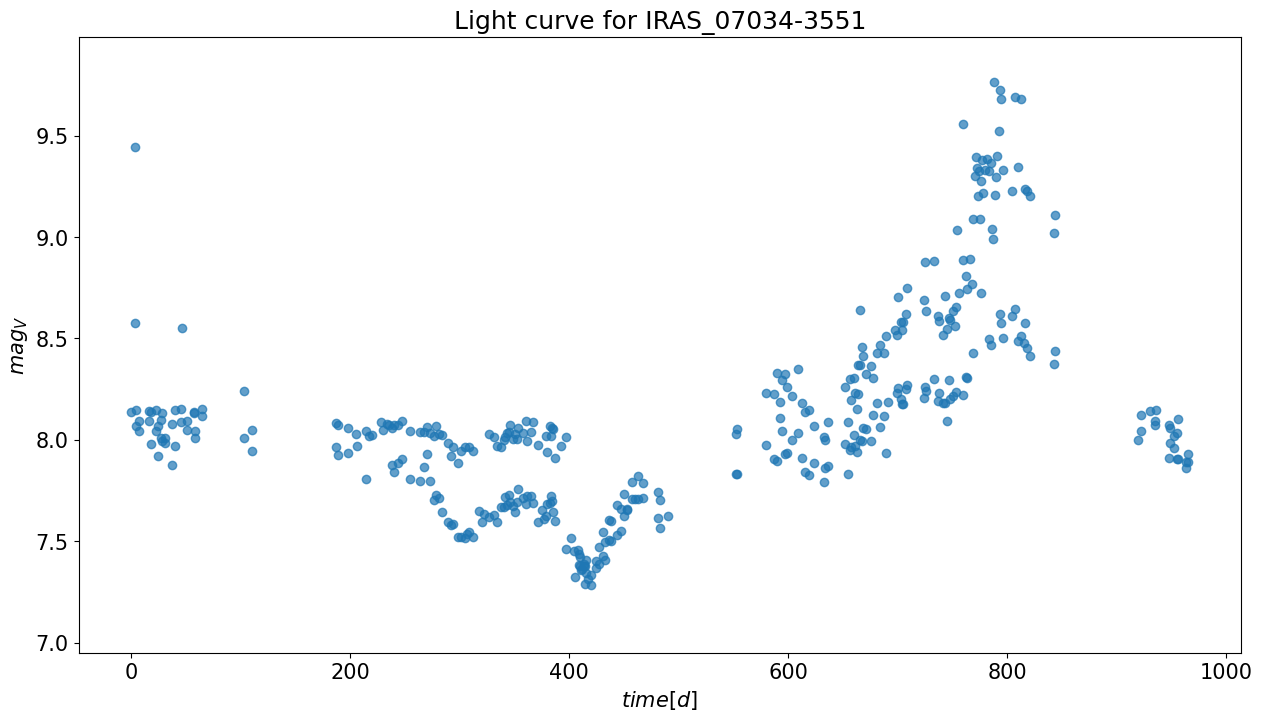

In [4]:
plt.rcParams.update({'font.size': 15}) 
plt.figure(figsize=(15,8))
plt.scatter(data['JD']-np.min(data['JD']),data['Magnitude'],marker= 'o',alpha = 0.7)
plt.ylabel(r"$mag_V$")
plt.xlabel(r"$time [d]$")
plt.ylim(mag_median-4.5 * madm_median, mag_median+8 * madm_median)
plt.title('Light curve for '+ stars_list[s])

We can observe that by transforming the light curve into a power spectrum using the Lomb-Scargle algorithm, we obtain peaks that represent different pulsation modes of the star. Identifying which of these peaks belong to the signal of our interest allows us to characterize the star

In [5]:
ls_g = LombScargle(data['JD'], data['Magnitude'])
freq_g, power_g = ls_g.autopower()

Text(0.5, 1.0, 'Power spectrum for IRAS_07034-3551')

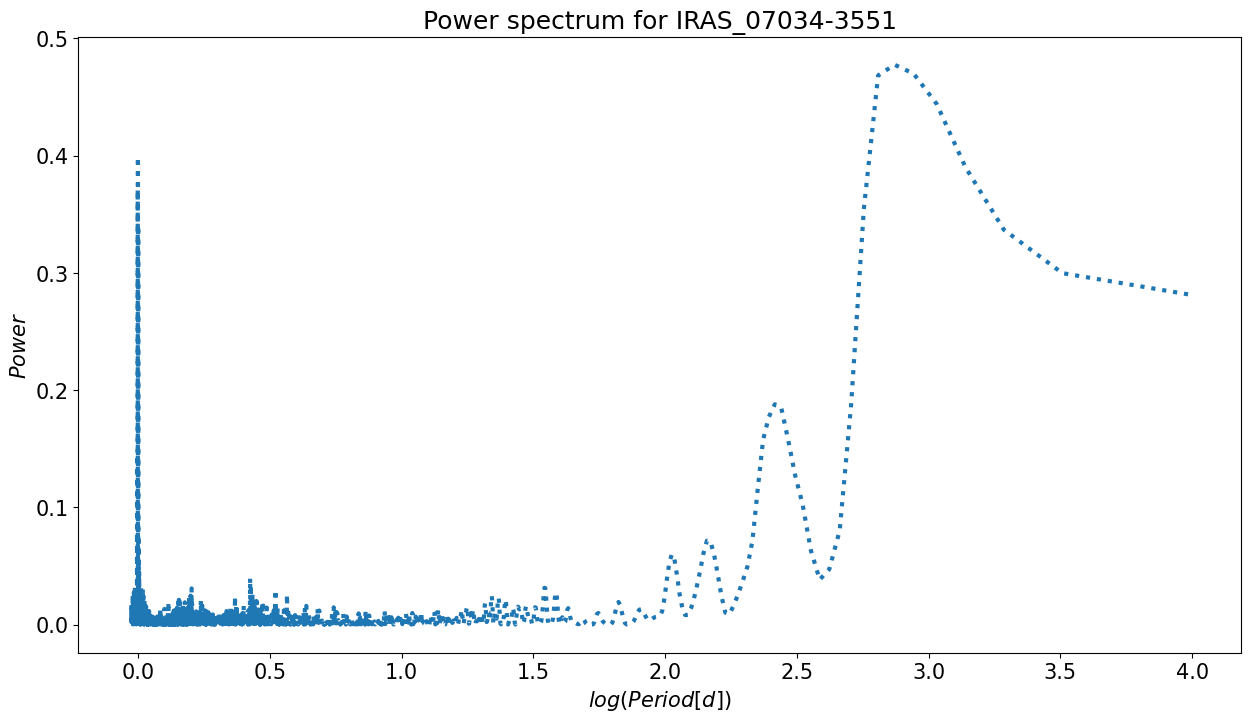

In [6]:
plt.rcParams.update({'font.size': 15}) 
plt.figure(figsize=(15,8))
plt.plot(np.log10(1/freq_g), power_g,linestyle=':',linewidth=3)
#plt.xlim(30,2000)
plt.ylabel(r"$Power$")
plt.xlabel(r"$log(Period [d])$")
plt.title('Power spectrum for ' + stars_list[s])

**You should motivate why the results might need improvement in some cases. This particular light curve isn't very noisy, and the short-term magnitude variation (due to noise, calibration issues, etc) is not very comparable to the long-term variation (due to the intrinsic variability of the source). In such a case, smoothing isn't absolutely necessary (for example, you've already isolated the fundamental peak and the first couple of overtones).**

Now we can try to improve the results by attempting to smooth the light curve using the Savitzky-Golay filter (`savgol_filter`) . This is the filter available in the `scipy` module. It takes the following parameters:

* `window_length`: the number of points used for smoothing. It must be an odd number to ensure symmetry around the evaluation point, both before and after it. (Smoothing a single point doesn't make sense, so $window\_length > 3$.)

* `polyorder`: smoothing is performed by fitting a polynomial to the data within the window. The constraint is that $polyorder ≤ window\_length - 1$.

There is a relationship between the window width and the frequencies that we want to eliminate, but that is not discussed at this point.

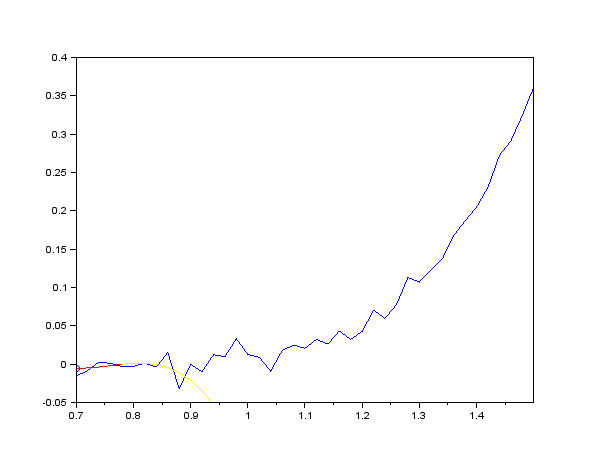

Two examples are shown where smoothing is performed using a straight line and windows of 3 and 9 points.

* Example 1:
  Window width: 3 points
  Polynomial order: 1 (green)

* Example 2:
  Window width: 9 points
  Polynomial order: 1 (red)

Text(0.5, 1.0, 'Light curve for IRAS_07034-3551')

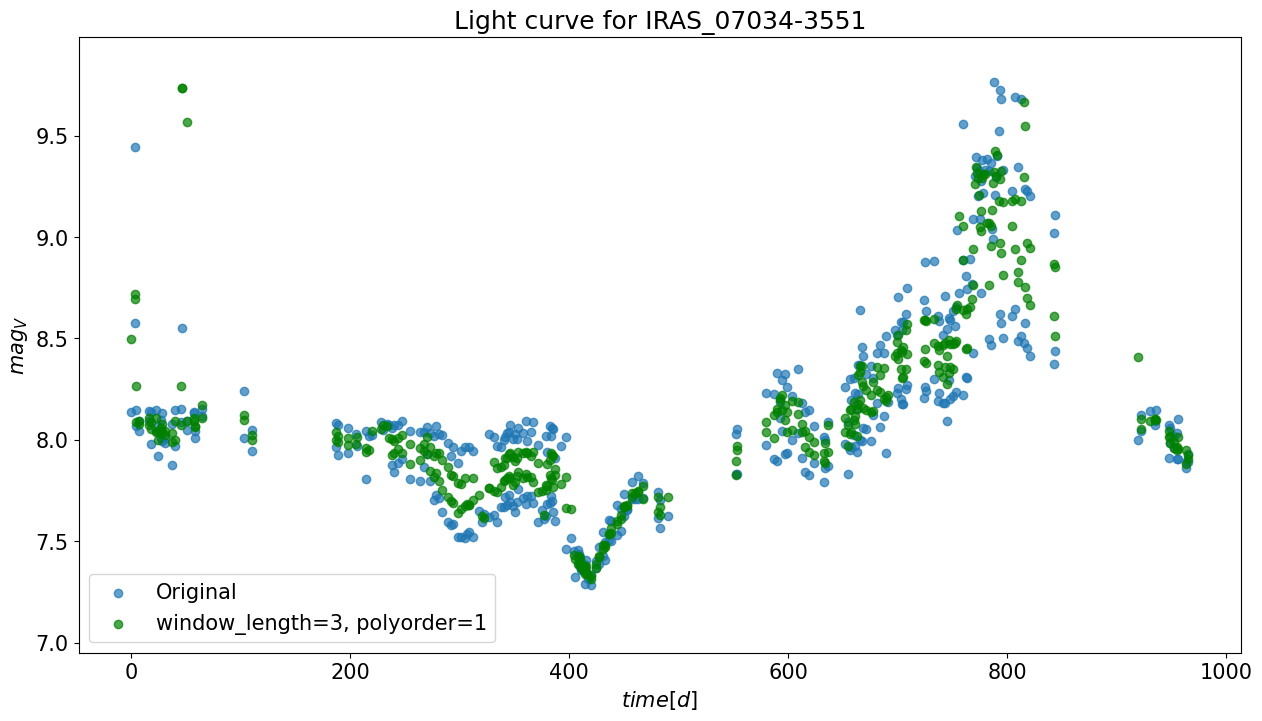

In [7]:
mag_smooth = savgol_filter(data['Magnitude'], 3, 1)
plt.rcParams.update({'font.size': 15}) 
plt.figure(figsize=(15,8))
plt.scatter(data['JD']-np.min(data['JD']),data['Magnitude'],marker= 'o',alpha = 0.7,label='Original')
plt.scatter(data['JD']-np.min(data['JD']),mag_smooth,color='g',marker= 'o',alpha = 0.7,label='window_length=3, polyorder=1')
plt.ylim(mag_median-4.5 * madm_median, mag_median+8 * madm_median)
plt.ylabel(r"$mag_V$")
plt.xlabel(r"$time [d]$")
plt.legend()
plt.title('Light curve for '+ stars_list[s])

Text(0.5, 1.0, 'Light curve for IRAS_07034-3551')

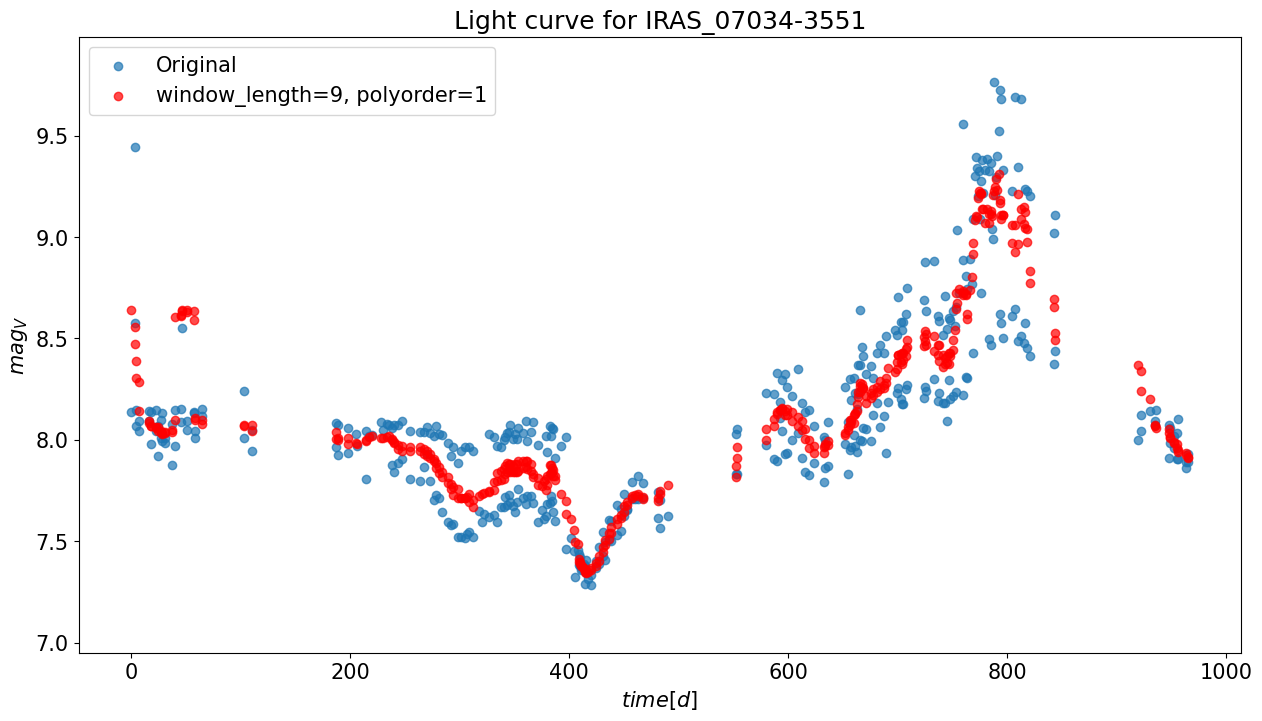

In [8]:
mag_smooth_2 = savgol_filter(data['Magnitude'], 9, 1)
plt.rcParams.update({'font.size': 15}) 
plt.figure(figsize=(15,8))
plt.scatter(data['JD']-np.min(data['JD']),data['Magnitude'],marker= 'o',alpha = 0.7,label='Original')
plt.scatter(data['JD']-np.min(data['JD']),mag_smooth_2,color='red',marker= 'o',alpha = 0.7,label='window_length=9, polyorder=1')
plt.ylim(mag_median-4.5 * madm_median, mag_median+8 * madm_median)
plt.ylabel(r"$mag_V$")
plt.xlabel(r"$time [d]$")
plt.legend()
plt.title('Light curve for '+ stars_list[s])


If we look at the power spectrum, we will see that the different modes gain higher power, indicating a higher probability of being a signal.

Text(0.5, 1.0, 'Power spectrum for IRASIRAS_07034-3551')

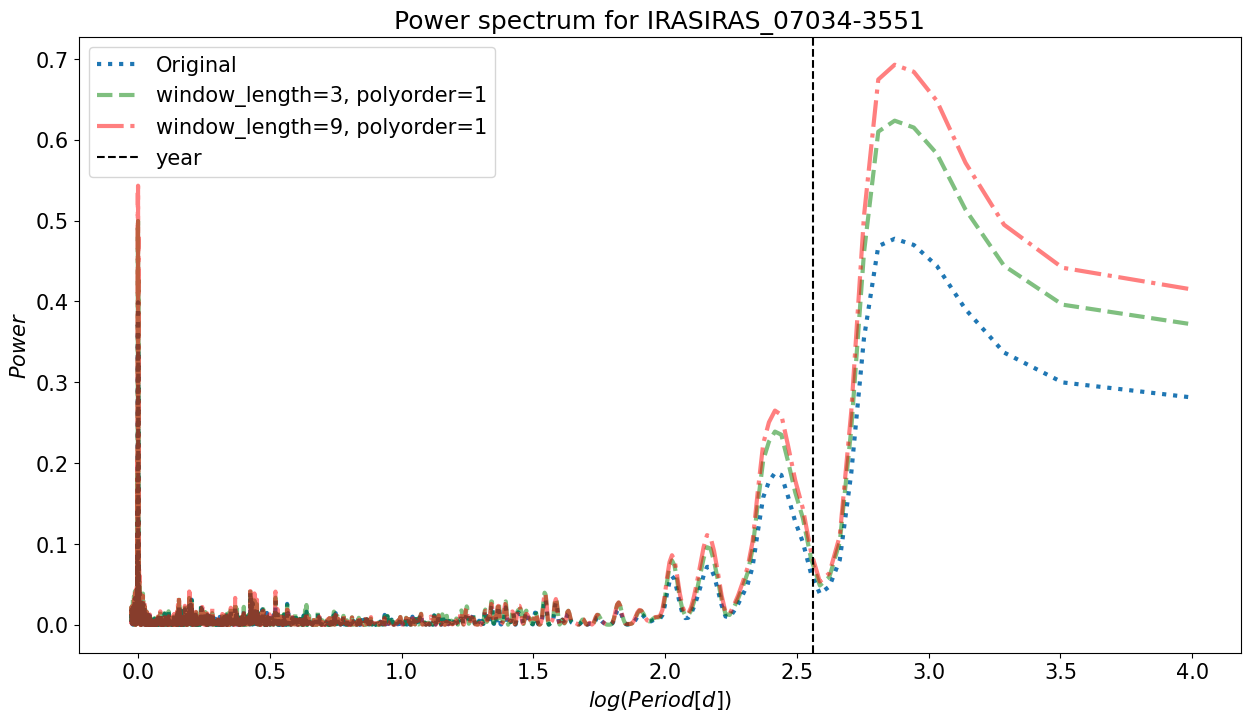

In [9]:
ls_g = LombScargle(data['JD'],mag_smooth)
freq_g_smo, power_g_smo = ls_g.autopower()
ls_g = LombScargle(data['JD'],mag_smooth_2)
freq_g_smo_2, power_g_smo_2 = ls_g.autopower()
plt.rcParams.update({'font.size': 15}) 
plt.figure(figsize=(15,8))
plt.plot(np.log10(1/freq_g), power_g,linestyle=':',linewidth=3,label='Original')
plt.plot(np.log10(1/freq_g_smo), power_g_smo,color='g',alpha=0.5,linestyle='--', linewidth=3,label='window_length=3, polyorder=1')
plt.plot(np.log10(1/freq_g_smo_2), power_g_smo_2,color='red',alpha=0.5,linestyle='-.',linewidth=3,label='window_length=9, polyorder=1')
plt.axvline(x=np.log10(365.25), color='k', linestyle='--',label='year')
plt.legend()
plt.ylabel(r"$Power$")
plt.xlabel(r"$log(Period [d])$")
plt.title('Power spectrum for IRAS' + stars_list[s])

Two examples are shown where smoothing is performed using a polynomial of order 2 and another of order 5 for a window of 9 points.

* Example 1:
  Window width: 9 points
  Polynomial order: 2 (green)

* Example 2:
  Window width: 9 points
  Polynomial order: 5 (red)

Text(0.5, 1.0, 'Light curve for IRAS_07034-3551')

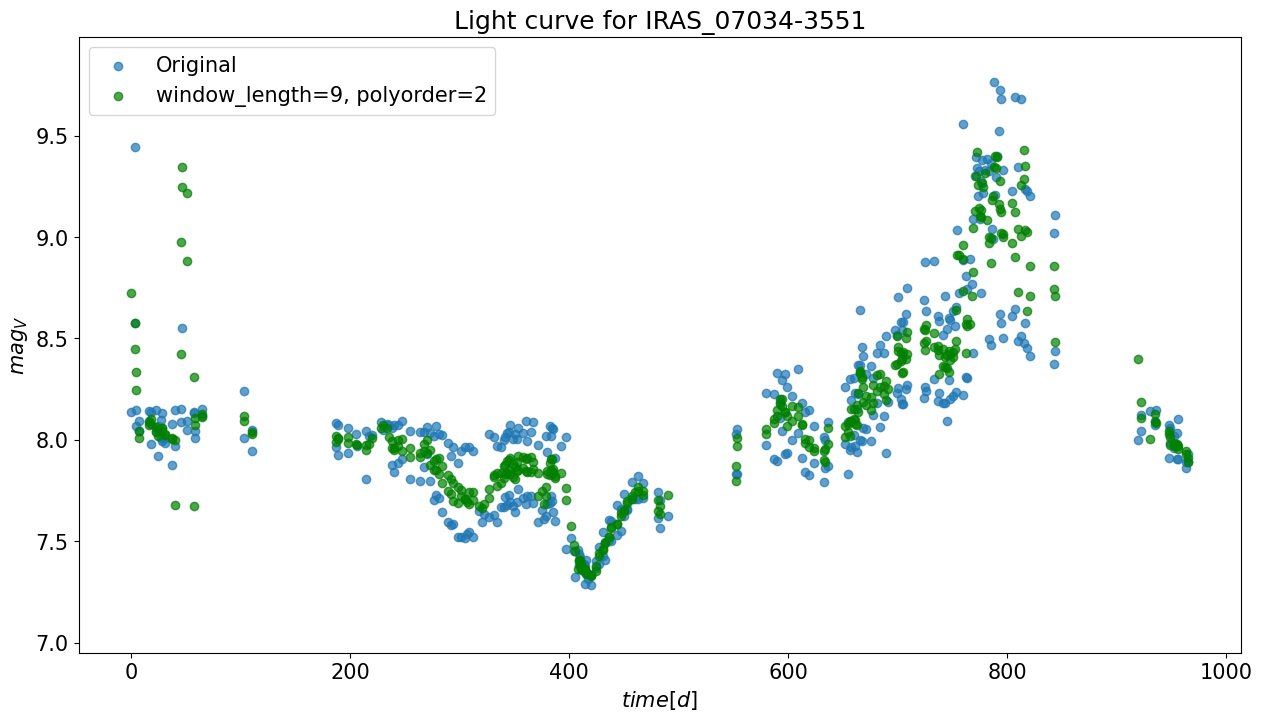

In [10]:
mag_smooth = savgol_filter(data['Magnitude'], 9, 2)
plt.rcParams.update({'font.size': 15}) 
plt.figure(figsize=(15,8))
plt.scatter(data['JD']-np.min(data['JD']),data['Magnitude'],marker= 'o',alpha = 0.7,label='Original')
plt.scatter(data['JD']-np.min(data['JD']),mag_smooth,color='g',marker= 'o',alpha = 0.7,label='window_length=9, polyorder=2')
plt.ylim(mag_median-4.5 * madm_median, mag_median+8 * madm_median)
plt.ylabel(r"$mag_V$")
plt.xlabel(r"$time [d]$")
plt.legend()
plt.title('Light curve for '+ stars_list[s])

Text(0.5, 1.0, 'Light curve for IRAS_07034-3551')

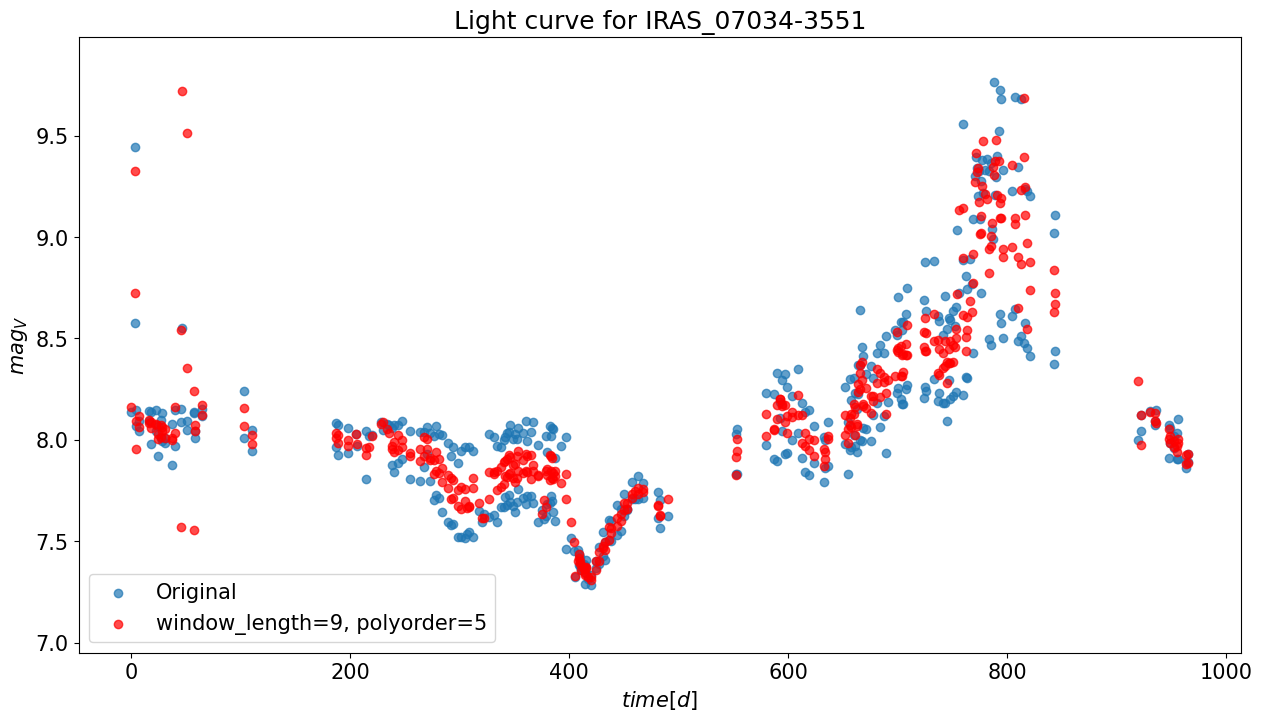

In [11]:
mag_smooth_2 = savgol_filter(data['Magnitude'], 9, 5)
plt.rcParams.update({'font.size': 15}) 
plt.figure(figsize=(15,8))
plt.scatter(data['JD']-np.min(data['JD']),data['Magnitude'],marker= 'o',alpha = 0.7,label='Original')
plt.scatter(data['JD']-np.min(data['JD']),mag_smooth_2,color='red',marker= 'o',alpha = 0.7,label='window_length=9, polyorder=5')
plt.ylim(mag_median-4.5 * madm_median, mag_median+8 * madm_median)
plt.ylabel(r"$mag_V$")
plt.xlabel(r"$time [d]$")
plt.legend()
plt.title('Light curve for '+ stars_list[s])

It can be observed that for a larger window, fitting a higher-order polynomial tends to bring us back to the original data. This is because having more degrees of freedom in the polynomial causes it to mimic the point distribution within the window.

Text(0.5, 1.0, 'Power spectrum for IRASIRAS_07034-3551')

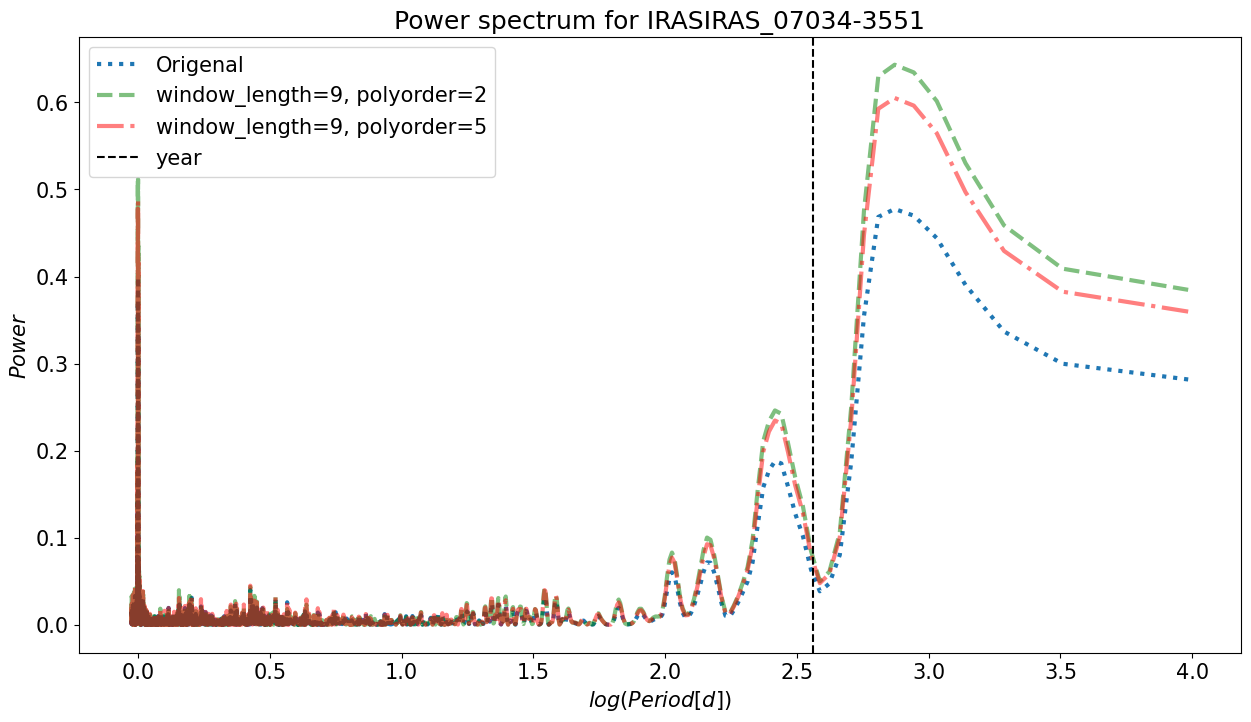

In [12]:
ls_g = LombScargle(data['JD'],mag_smooth)
freq_g_smo, power_g_smo = ls_g.autopower()
ls_g = LombScargle(data['JD'],mag_smooth_2)
freq_g_smo_2, power_g_smo_2 = ls_g.autopower()
plt.rcParams.update({'font.size': 15}) 
plt.figure(figsize=(15,8))
plt.plot(np.log10(1/freq_g), power_g,linestyle=':',linewidth=3,label='Origenal')
plt.plot(np.log10(1/freq_g_smo), power_g_smo,color='g',alpha=0.5,linestyle='--', linewidth=3,label='window_length=9, polyorder=2')
plt.plot(np.log10(1/freq_g_smo_2), power_g_smo_2,color='red',alpha=0.5,linestyle='-.',linewidth=3,label='window_length=9, polyorder=5')
plt.axvline(x=np.log10(365.25), color='k', linestyle='--',label='year')
plt.legend()
plt.ylabel(r"$Power$")
plt.xlabel(r"$log(Period [d])$")
plt.title('')
plt.title('Power spectrum for IRAS' + stars_list[s])

# Automatically identifying period peaks.

The function `find_peaks` in the `scipy` module allows us to identify all the peaks in the periodogram.

Now, let's take the best-smoothed light curve example (9,1). We will identify all the peaks.

In [13]:
mag_smooth_2 = savgol_filter(data['Magnitude'], 9, 1)
ls_g = LombScargle(data['JD'],mag_smooth_2)
freq_g, power_g= ls_g.autopower()

In [14]:
arg_max_P = signal.find_peaks(power_g)[0]

The `find_peaks` function identifies local maxima and minima by comparing the amplitudes in a neighborhood around each point in a one-dimensional sample.

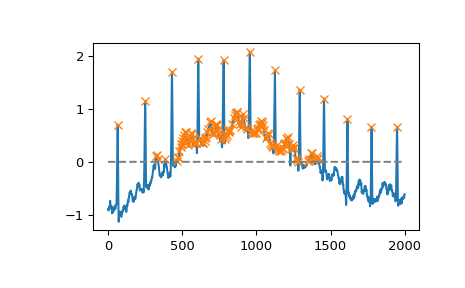

In [16]:
power_peak=power_g[arg_max_P]
freq_peak=freq_g[arg_max_P]

Text(0.5, 1.0, 'Power spectrum for IRASIRAS_07034-3551')

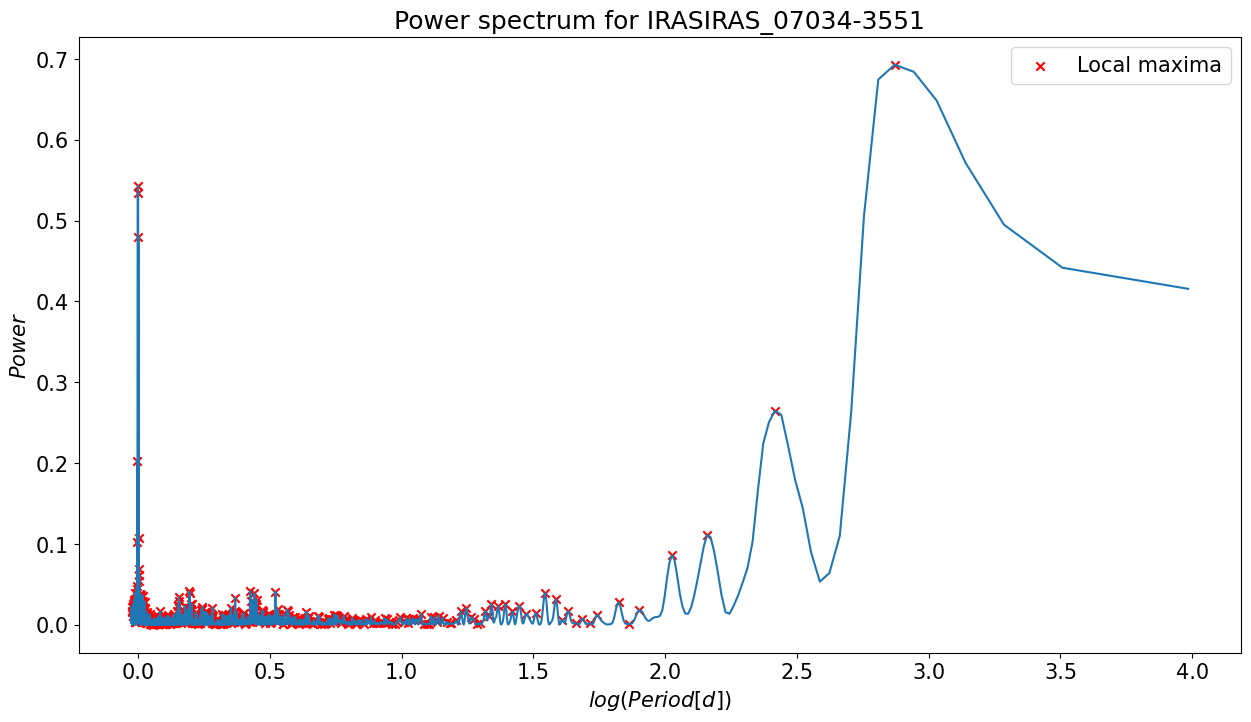

In [17]:
plt.figure(figsize=(15,8))
plt.rcParams.update({'font.size': 15}) 
plt.plot(np.log10(1.0/freq_g), power_g)
plt.scatter(np.log10(1.0/freq_peak),power_peak,marker='x',color='red',label='Local maxima')
plt.ylabel(r"$Power$")
plt.xlabel(r"$log(Period [d])$")
plt.legend()
plt.title('Power spectrum for IRAS' + stars_list[s])

# Isolating true period peaks.

In the periodogram, the peaks indicate pulsation modes, and the higher the peak, the higher the probability of it being a signal. However, in a data sample with a significant noise, this may not hold true.

Once we have used `find_peaks` to identify all the peaks, we can use another function to determine which of these peaks are true signal.

Now, as we are interested in rejecting the period values for the peaks that have a minimum probability of 0.05 of being noise.

The probability of a noise peak being falsely identified as true signal is called the **false alarm probability** (FAlP).

The  power is known to have values ranging from 0 to 1. By utilizing a function `false_alarm_probability`, we can determine the minimum power value at which the probability reaches 0.05. Any power values surpassing this threshold will be classified as object pulsation modes.


In [18]:
prob_threshold=0.05
power_r = np.linspace(0, 1, 1000)
pro_ls=ls_g.false_alarm_probability(power=power_r)

index=pro_ls<prob_threshold
pro_ls=pro_ls[index]
power_r=power_r[index]
arg=np.argmax(pro_ls)
power_max=power_r[arg]

In [19]:
index_p=power_peak>(power_max)
try:
  f=freq_peak[index_p]
  p=power_peak[index_p]
except:
  f=freq_g
  p=power_g

Text(0.5, 1.0, 'Power spectrum for IRASIRAS_07034-3551')

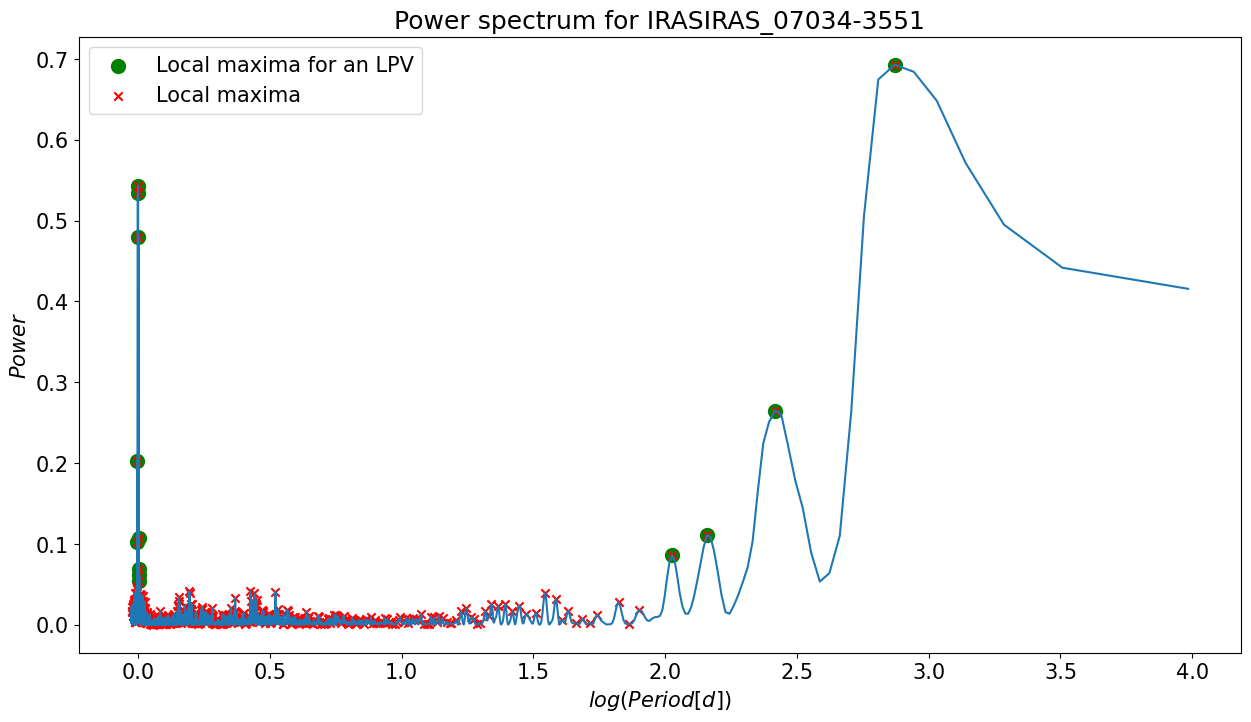

In [20]:
plt.figure(figsize=(15,8))
plt.rcParams.update({'font.size': 15}) 
plt.plot(np.log10(1.0/freq_g), power_g)
plt.scatter(np.log10(1.0/f),p,marker='o',c='g',s=100,label='Local maxima for an LPV')
plt.scatter(np.log10(1.0/freq_peak),power_peak,marker='x',color='red',label='Local maxima')
plt.ylabel(r"$Power$")
plt.xlabel(r"$log(Period [d])$")
plt.legend()
plt.title('Power spectrum for IRAS' + stars_list[s])


Now, the slim and very short period peak ($p\sim 0$) is not considered a pulsation mode of the star. This can be found in the literature, where it is indicated that stars in the Large Magellanic Cloud pulsate in a range of 30 to 2000 (Riebel [2010]) in different modes. Therefore, from a statistical perspective of stars with long periods, we can discard peaks that fall outside that range.

In [ ]:
index_f=(1/2000.0)<f
f=f[index_f]
p=p[index_f]

index_f=f<(1/30.0)
f=f[index_f]
p=p[index_f]

Text(0.5, 1.0, 'Power spectrum for IRASIRAS_07034-3551')

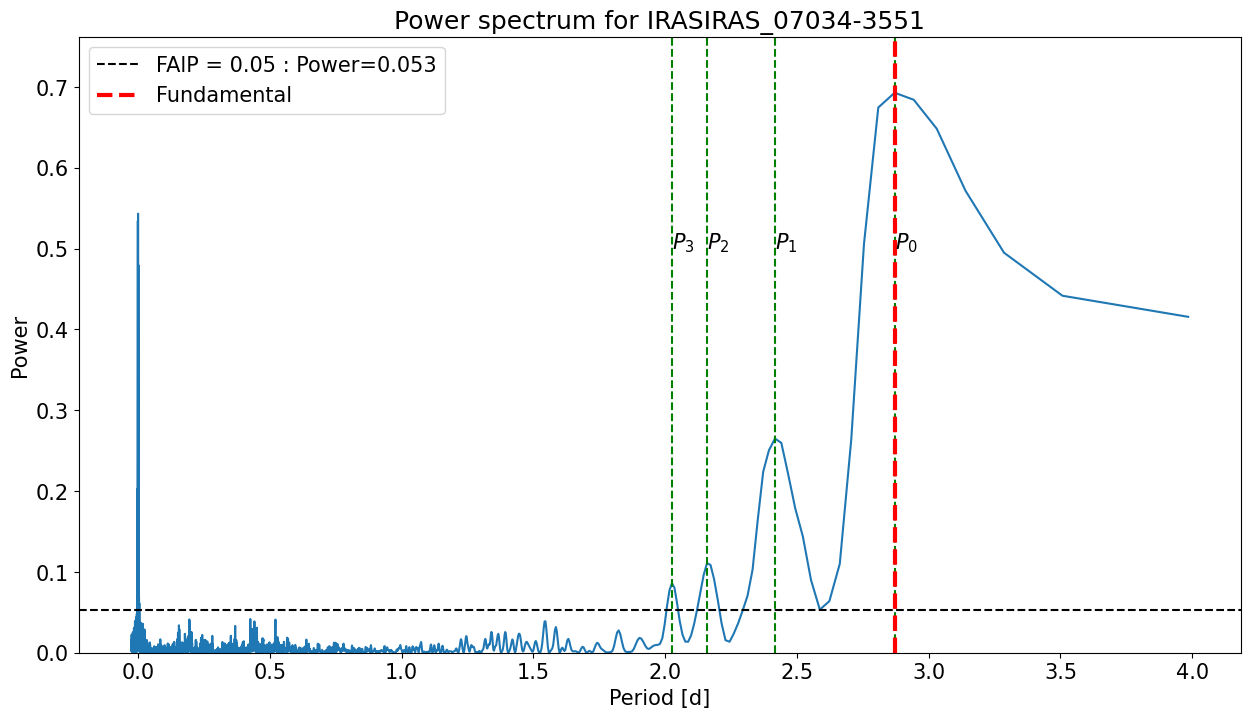

In [ ]:
modes=['$P_0$','$P_1$','$P_2$','$P_3$']
arg_pow_max=np.argmax(p)
funadamen=(1/f[arg_pow_max])

plt.figure(figsize=(15,8))
plt.rcParams.update({'font.size': 15}) 
plt.plot(np.log10(1.0/freq_g), power_g)
plt.axhline(y=power_r[arg], color='black', linestyle='--',\
            label='FAlP = 0.05 : Power='+str(round(power_r[arg],3)))
for i,m in zip(1/f,modes):
    plt.axvline(x=np.log10(i), color='g', linestyle='--',label='')
    plt.text(np.log10(i), 0.5, m)

plt.axvline(x=np.log10(funadamen), color='r', linestyle='--',label='Fundamental',linewidth=3)

#for i in range(2,8):
#  plt.axvline(x=np.log10(funadamen/i), color='purple', linestyle=':',label='',linewidth=3)
#  print(funadamen/i)
#plt.xlim([30, 2000])
plt.ylim([0,np.max(p)+0.1*np.max(p)])
plt.xlabel("Period [d]")
plt.ylabel("Power")
plt.legend()
plt.title('Power spectrum for IRAS' + stars_list[s])


These are the different pulsation modes for this star that do not follow the relationship $p_{ (n-1)}=\frac{p_o}{n}$ with $n>0$.

In [ ]:
for i,m in zip(1/f,range(0,4)):
  print('p_'+str(m),'=',round(i.value,2))

p_0 = 742.44
p_1 = 260.86
p_2 = 144.06
p_3 = 106.06



Curiously, this holds true for odd values of $n$.

In [ ]:
imp=[1,3,5,7]
for m in imp:
  print('p_'+str(m-1)+'(n='+str(m)+')','=',round((funadamen/m).value,2))

p_0(n=1) = 742.44
p_2(n=3) = 247.48
p_4(n=5) = 148.49
p_6(n=7) = 106.06


Polynomial coefficients: [ 0.92857143 -5.07142857  8.2       ]
Predictions: [4.05714286 1.77142857 1.34285714 2.77142857 6.05714286]


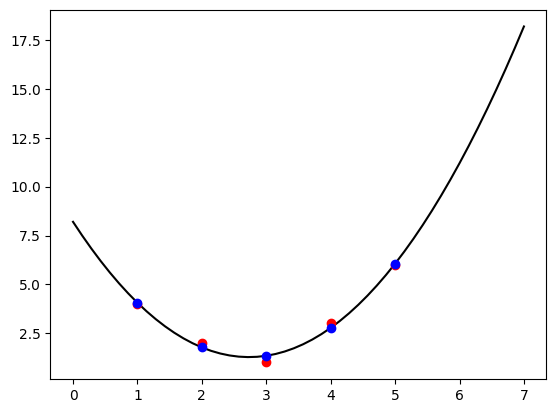

In [5]:
import numpy as np
import matplotlib.pyplot as plt

# Define the input data points
x = np.array([1, 2, 3, 4, 5])   # x values
y = np.array([4, 2, 1, 3, 6])   # y values

# Fit a polynomial of degree 3
coefficients = np.polyfit(x, y, 2)

# Generate predictions at the same x values
predictions = np.polyval(coefficients, x)

# Print the coefficients and predictions
print("Polynomial coefficients:", coefficients)
print("Predictions:", predictions)

xgrid = np.linspace(0, 7)
plt.plot(xgrid, np.polyval(coefficients, xgrid), 'k-')
plt.plot(x, y, 'ro', label = 'original data')
plt.plot(x, np.polyval(coefficients, x), 'bo', label = 'predictions')